In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.util.infeasible import log_infeasible_constraints
import logging

from datetime import datetime, timedelta
import pickle
import json
# from pyomo.util.infeasible import log_infeasible_constraints
# import logging
#
# from sklearn.cluster import KMeans
# from sklearn import metrics
# from scipy.spatial.distance import cdist
# from sklearn.preprocessing import StandardScaler


In [31]:
# Basic Setting
grid = "369_0"
#this_day = '2050-05-06'
#this_weekday = 'Friday'
next_two = True # True consider next 2 trips,False consider only next 1 trip
#date = 6
scenario_year = 2050
day_start_ts = pd.to_datetime(f"{scenario_year}-05-06")
day_start = day_start_ts.day
day_end_ts = pd.to_datetime(f"{scenario_year}-05-09")
monitor_hr = int((day_end_ts - day_start_ts).total_seconds()/3600)
path = f"{grid}/split_v5_{scenario_year}_multidays"
participate_rate = 1  # 1 no constraints on participation rate, parking event based, not vehicle based
min_power_level = 1 # 1 constant power request at max. charger power, otherwise set a lower limit on power requested: min_power_level * max_power

In [25]:
# Data Preprocessing
def calculate_next_trip_e(row):
    if next_two and (row['next_parking_time']<60):
        next_trip_e = row['next_travel_TP1_consumption']+row['next_2_travel_TP1_consumption']
    else:
        next_trip_e =  row['next_travel_TP1_consumption']
    return next_trip_e

def get_hour_index(ts):
    idx = int(divmod((ts-day_start_ts).total_seconds(),3600)[0]) 
    return idx

def get_soe_init(SoE_bc,arr_idx):
    soe_init_list = [0]*monitor_hr
    for idx in range(arr_idx+1):
        soe_init_list[idx] = SoE_bc
    return soe_init_list

# def create_dict(row,start_ts,end_ts):
#     dict = [0]*monitor_hr
#     arr_day_no = (start_ts-day_start_ts).days
#     park_end_day_no = (end_ts-day_start_ts).days
#     
#     for day in range(monitor_hr//24):
#         for hour in range(24):
#             if (park_end_day_no==day) & (row['park_end_hour']>hour) & (arr_day_no==day)&(row['arr_hour']<hour): 
#                 dict[day*24+hour] = 60
#             elif (park_end_day_no==day) & (row['park_end_hour']>hour) & (arr_day_no<day):
#                 dict[day*24+hour] = 60
#             elif (park_end_day_no>day) & (arr_day_no==day)&(row['arr_hour']<hour): 
#                 dict[day*24+hour] = 60
#             elif (park_end_day_no>day) & (arr_day_no<day):
#                 dict[day*24+hour] = 60
#             elif (park_end_day_no==day) & (row['park_end_hour']>hour) & (arr_day_no==day)&(row['arr_hour']==hour): 
#                 dict[day*24+hour] = 60-start_ts.minute
#             elif  (park_end_day_no>day) & (row['arr_hour']==hour)&(arr_day_no==day):
#                 dict[day*24+hour] = 60-start_ts.minute
#             elif (row['park_end_hour']==hour) & (park_end_day_no==day) & (row['arr_hour']<hour) & (arr_day_no==day):
#                 dict[day*24+hour] = end_ts.minute
#             elif (row['park_end_hour']==hour) & (park_end_day_no==day) & (arr_day_no<day):
#                 dict[day*24+hour] = end_ts.minute
#             elif (row['park_end_hour']==hour) & (park_end_day_no==day) & (row['arr_hour']==hour) & (arr_day_no==day):
#                 dict[day*24+hour] = end_ts.minute-start_ts.minute
#             else:
#                 dict[day*24+hour]=0
#     return dict

def create_dict(start_ts,end_ts,start_hour_idx,end_hour_idx):
    if end_hour_idx>monitor_hr-1:
        end_hour_idx = monitor_hr-1
    dict = [0]*monitor_hr
    for hour in range(monitor_hr):
        if start_hour_idx<hour and end_hour_idx>hour:
            dict[hour] = 60
        elif start_hour_idx==hour and end_hour_idx==hour:
            dict[hour] = end_ts.minute-start_ts.minute
        elif start_hour_idx<hour and end_hour_idx==hour:
            dict[hour] = end_ts.minute
        elif start_hour_idx==hour and end_hour_idx>hour:
            dict[hour] = 60-start_ts.minute
    return dict

# def create_charge_time_list(row,start_ts,end_ts):
#     dict = [0]*monitor_hr
#     arr_day_no = (start_ts-day_start_ts).days
#     charge_end_day_no = (end_ts-day_start_ts).days
#     charge_start_hour = start_ts.hour
#     charge_end_hour = end_ts.hour
#     if row['c']:
#         for day in range(monitor_hr//24):
#             for hour in range(24):
#                 if (charge_end_day_no==day) & (charge_end_hour>hour) & (arr_day_no==day)&(charge_start_hour<hour): 
#                     dict[day*24+hour] = 60
#                 elif (charge_end_day_no==day) & (charge_end_hour>hour) & (arr_day_no<day):
#                     dict[day*24+hour] = 60
#                 elif (charge_end_day_no>day) & (arr_day_no==day)&(charge_start_hour<hour): 
#                     dict[day*24+hour] = 60
#                 elif (charge_end_day_no>day) & (arr_day_no<day):
#                     dict[day*24+hour] = 60
#                 elif (charge_end_day_no==day) & (charge_end_hour>hour) & (arr_day_no==day)&(charge_start_hour==hour): 
#                     dict[day*24+hour] = 60-start_ts.minute
#                 elif  (charge_end_day_no>day) & (charge_start_hour==hour)&(arr_day_no==day):
#                     dict[day*24+hour] = 60-start_ts.minute
#                 elif (charge_end_hour==hour) & (charge_end_day_no==day) & (charge_start_hour<hour) & (arr_day_no==day):
#                     dict[day*24+hour] = end_ts.minute
#                 elif (charge_end_hour==hour) & (charge_end_day_no==day) & (arr_day_no<day):
#                     dict[day*24+hour] = end_ts.minute
#                 elif (charge_end_hour==hour) & (charge_end_day_no==day) & (charge_start_hour==hour) & (arr_day_no==day):
#                     dict[day*24+hour] = end_ts.minute-start_ts.minute
#                 else:
#                     dict[day*24+hour]=0
#     return dict
def create_charge_time_list(charge_decision, start_ts, end_ts, start_hour_idx,end_hour_idx):
    if end_hour_idx>monitor_hr-1:
        end_hour_idx = monitor_hr-1  
    dict = [0]*monitor_hr
    if charge_decision:
        for hour in range(monitor_hr):
            if start_hour_idx<hour and end_hour_idx>hour:
                dict[hour] = 60
            elif start_hour_idx==hour and end_hour_idx==hour:
                dict[hour] = end_ts.minute-start_ts.minute
            elif start_hour_idx<hour and end_hour_idx==hour:
                dict[hour] = end_ts.minute
            elif start_hour_idx==hour and end_hour_idx>hour:
                dict[hour] = 60-start_ts.minute
    return dict
# Data Postprocessing
# def get_timestamp_pair(row):
#     process = {}
#     process_key = ()
#     power = []
#     for hour in range(24):
#         p_t = row['optimized_power_list'][hour]
#         min_t = row['hourly_time_dict'][hour]
#         if hour>0:
#             min_pre, p_pre = row['hourly_time_dict'][hour-1],row['optimized_power_list'][hour-1]
#         else: 
#             min_pre,p_pre = 0,0
#         if hour<23:
#             min_next, p_next = row['hourly_time_dict'][hour+1],row['optimized_power_list'][hour+1]
#         else:
#             min_next, p_next = 0,0
#         if p_pre==0 and p_t!=0:
#             if (min_t == 60 or min_pre==60) and (hour!=row['arr_time'].hour):
#                 start_min = 0
#             elif (min_t<60 and min_pre!=60 and min_t>0) and (hour!=row['arr_time'].hour):
#                 start_min = 60-min_t
#             elif (hour==row['arr_time'].hour):
#                 start_min = row['arr_time'].minute
#             else:
#                 start_min = 0
#             start_ts = pd.Timestamp(datetime(year=scenario_year,month=5,day=date,hour=hour,minute=start_min))
#             process_key = (start_ts,)
#         if p_t!=0:
#             power.append(p_t)
#         if p_next==0 and p_t!=0:
#             if (min_t==60 or min_next>0) and (hour!=row['park_end_time'].hour):
#                 end_min=59
#             elif (min_t<60 and min_next==0 and min_pre>0) and (hour!=row['park_end_time'].hour):
#                 end_min=min_t
#             elif (hour==row['park_end_time'].hour):
#                 end_min=row['park_end_time'].minute
#             else:
#                 end_min = 0
#             end_ts = pd.Timestamp(datetime(year=scenario_year,month=5,day=date,hour=hour,minute=end_min))
#             process_key = process_key + (end_ts,)
#             process[process_key] = power
#             process_key = ()
#             power = []
#     return process


In [26]:
df = pd.read_csv("/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/grid369_mobility_dataset.csv")
df['dep_time'] = pd.to_datetime(df['dep_time'],format='mixed')
df['arr_time'] = pd.to_datetime(df['arr_time'],format='mixed')
df['st_chg_time'] = pd.to_datetime(df['st_chg_time'],format='mixed')
df['ed_chg_time'] = pd.to_datetime(df['ed_chg_time'],format='mixed')
df['chg_time'] = pd.to_timedelta(df['ed_chg_time']-df['st_chg_time'],unit='m')

df['dep_time'] = df['dep_time'] + pd.DateOffset(days=3)
df['dep_time'] = df.apply(lambda row:row['dep_time'].replace(year=scenario_year), axis=1)

df['arr_time'] = df['dep_time'] + pd.to_timedelta(df['trav_time'], unit='m')
df['arr_hour'] = df['arr_time'].dt.hour
df['arr_time_idx'] = df.apply(lambda x:get_hour_index(x['arr_time']), axis=1)
df['arr_day'] = df['arr_time'].dt.day
df['arr_type_day'] = df['arr_time'].dt.dayofweek

df['park_end_time'] = df['arr_time']+pd.to_timedelta(df['parking_time'],unit='m')
df['park_end_hour'] = df['park_end_time'].dt.hour
df['park_end_time_idx'] = df.apply(lambda x:get_hour_index(x['park_end_time']), axis=1)
df['park_end_day'] = df['park_end_time'].dt.day
df['park_end_type_day'] = df['park_end_time'].dt.dayofweek

df['st_chg_time'] = df.apply(lambda row: row['st_chg_time'].replace(day=row['arr_time'].day, month=row['arr_time'].month, year=row['arr_time'].year), axis=1)
df['st_chg_time_idx'] = df.apply(lambda x:get_hour_index(x['st_chg_time']),axis=1)
df['ed_chg_time'] = df['st_chg_time']+df['chg_time']
df['ed_chg_time_idx'] = df.apply(lambda x:get_hour_index(x['ed_chg_time']),axis=1)
df['chg_time'] = df['chg_time'].dt.total_seconds()/60

df.sort_values(by=['person','dep_time'])
df['next_travel_TP1_consumption'] = df.groupby('person')['TP1 consumption kWh'].shift(-1).fillna(0)
df['next_parking_time'] = df.groupby('person')['parking_time'].shift(-1).fillna(0)
df['next_2_travel_TP1_consumption'] = df.groupby('person')['TP1 consumption kWh'].shift(-2).fillna(0)
df['next_trip_e'] = df.apply(calculate_next_trip_e,axis=1)
df.drop(['next_parking_time', 'next_travel_TP1_consumption', 'next_2_travel_TP1_consumption', 'TP1 rate kWh/100 km',
         'TP2 rate kWh/100 km', 'TP2 consumption kWh',
         'TP3 rate kWh/100 km', 'TP3 consumption kWh', 'TP4 rate kWh/100 km',
         'TP4 consumption kWh', 'st_mun_name', 'st_canton_name', 'st_urb_type',
         'st_mnt_type', 'ed_mun_name', 'ed_canton_name', 'ed_urb_type',
         'ed_mnt_type', 'Yearly kWh'], axis=1, inplace=True)
d = df[(df['grid'] == "369_0")] #& ((df['type_day'] == 'Thursday') | (df['type_day'] == 'Friday'))]
# d = d[(d['park_end_time']>=day_start_ts) & (d['arr_time']<day_end_ts)]
d = d[(d['arr_time']>=day_start_ts) & (d['arr_time']<day_end_ts)]
d['max_chg_e'] = d['B']-d['SoE_bc']
d['real_chg_e'] = d['SoE_ac']-d['SoE_bc']
d['hourly_time_dict'] = d.apply(lambda x:create_dict(x.arr_time,x.park_end_time,x.arr_time_idx,x.park_end_time_idx), axis =1)
d['charge_time_list'] = d.apply(lambda x:create_charge_time_list(x.c,x.st_chg_time,x.ed_chg_time,x.st_chg_time_idx,x.ed_chg_time_idx), axis=1)
d['charge_power_list'] = d.apply(lambda x: [x['chg rate'] if t >30 else 0 for t in x['charge_time_list']], axis=1)
d['charge_energy_list'] = d.apply(lambda x:[t/60*x['chg rate']for t in x['charge_time_list']], axis=1)
d['is_first'] = ~d.duplicated(subset='person', keep='first')
d['is_first'] = d['is_first'].astype(bool)
d['soe_init'] = d.apply(lambda x:get_soe_init(x.SoE_bc,x.arr_time_idx), axis=1)
d.insert(0,'event_index',d.index)
d.head(100)

,event_index,person,dep_time,trav_time,traveled_distance,start_activity_type,end_activity_type,start_x,start_y,end_x,...,ed_chg_time_idx,next_trip_e,max_chg_e,real_chg_e,hourly_time_dict,charge_time_list,charge_power_list,charge_energy_list,is_first,soe_init
170,170,63620,2050-05-06 10:59:57,25.000000,30.753000,work,leisure,2689194.0,1249241.0,2701360.0,...,11,9.236092,25.96,0.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 35, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,"[94.04, 94.04, 94.04, 94.04, 94.04, 94.04, 94...."
174,174,63620,2050-05-07 10:59:57,25.000000,30.753000,work,leisure,2689194.0,1249241.0,2701360.0,...,35,9.236092,38.96,0.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,"[81.04, 81.04, 81.04, 81.04, 81.04, 81.04, 81...."
177,177,63620,2050-05-08 08:29:57,92.376797,114.276137,home,leisure,2694256.0,1192129.0,2701360.0,...,59,67.111228,33.62,33.62,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,"[86.38, 86.38, 86.38, 86.38, 86.38, 86.38, 86...."
179,179,63620,2050-05-08 14:29:57,92.376797,114.276137,home,leisure,2694256.0,1192129.0,2701360.0,...,65,33.847667,67.11,43.13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,"[52.89, 52.89, 52.89, 52.89, 52.89, 52.89, 52...."
313,313,94876,2050-05-06 13:32:23,66.400000,83.588000,home,leisure,2724691.0,1220053.0,2697286.0,...,14,29.659693,34.79,0.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,"[55.21, 55.21, 55.21, 55.21, 55.21, 55.21, 55...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3294,3294,379810,2050-05-07 12:21:29,101.722205,68.824990,home,other,2682726.0,1225573.0,2702078.0,...,38,20.724494,28.60,0.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,"[41.4, 41.4, 41.4, 41.4, 41.4, 41.4, 41.4, 41...."
3361,3361,398690,2050-05-06 22:38:27,71.166667,69.119000,home,leisure,2686677.0,1220961.0,2697274.0,...,23,24.946879,19.91,0.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,"[100.09, 100.09, 100.09, 100.09, 100.09, 100.0..."
3363,3363,398690,2050-05-07 21:38:27,71.166667,69.119000,home,leisure,2686677.0,1220961.0,2697274.0,...,48,24.910692,64.25,44.31,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,"[55.75, 55.75, 55.75, 55.75, 55.75, 55.75, 55...."
3365,3365,398690,2050-05-08 11:38:27,71.166667,69.119000,home,leisure,2686677.0,1220961.0,2697274.0,...,62,24.605134,63.85,44.31,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,"[56.15, 56.15, 56.15, 56.15, 56.15, 56.15, 56...."


In [6]:
# Normalize Tobia's Nexus Output
hv_bus = str(89)
# Controlled charging
charge = pd.read_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/extracted_data/map_bus/Added_up_charge_{scenario_year}_raw.csv") # in MW
# charge.rename(columns={'Unnamed: 0':'ts'}, inplace=True)
charge['ts'] = pd.to_datetime(charge['ts'])
charge = charge.loc[(charge.ts<day_end_ts) & (charge.ts>=day_start_ts)][['ts','peak',hv_bus]]
# Controlled discharging
discharge = pd.read_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/extracted_data/map_bus/EVBatt_power_hourly_{scenario_year}_discharge_mapped.csv")
discharge = discharge.rename(columns={'Unnamed: 0':'ts'})
discharge['ts'] = pd.to_datetime(discharge['ts'])
discharge = discharge.loc[(discharge.ts<day_end_ts) & (discharge.ts>=day_start_ts)][['ts',hv_bus]]
# Find Netload Max
net= charge['89']-discharge['89']
period_max = net.max()
charge['normalized_profile'] = charge[hv_bus]/period_max
charge.index=range(monitor_hr)
discharge['normalized_profile'] = discharge[hv_bus]/period_max
discharge.index=range(monitor_hr)
net = charge['89']-discharge['89']
net_normalized = net/period_max
net_normalized

0     0.917176
1     0.741946
2     0.484770
3     0.304609
4     0.188007
        ...   
67    0.736173
68    0.670983
69    0.584428
70    0.539306
71    0.483873
Name: 89, Length: 72, dtype: float64

In [8]:
clustered = d.sort_values(by=['arr_time','parking_time'])
k = 30
group = np.arange(len(clustered)) % k
clustered['cluster']=group

In [32]:
def opt_charge_profile(charge,discharge,net_normalized,cluster,emob_max_p,normalized_tot_e,cluster_i,path):
    t_list = list(range(monitor_hr))
    e_list = list(cluster.event_index)
    tomatch_c = charge['normalized_profile']
    tomatch_d = discharge['normalized_profile']
    tomatch_net = net_normalized
    event_cnt = len(cluster)

    
    m = ConcreteModel()
    ############################
    # Set
    m.E = Set(initialize=e_list) # parking event set
    m.T = Set(initialize=t_list) # hour of the day
    ############################
    # Decision Variable
    m.charge_power = Var(m.E, m.T,within=NonNegativeReals,bounds=(0,1.5),initialize=0) 
    m.discharge_power = Var(m.E,m.T,within=NonNegativeReals,bounds=(0,1),initialize=0)
    
    # m.is_parked = Var(m.E, m.T, within=Binary)
    m.is_charging = Var(m.E,m.T,within=Binary,initialize=0)
    m.is_discharging = Var(m.E,m.T,within=Binary,initialize=0)
    m.is_active = Var(m.E,within=Binary,initialize=0)
    m.charge_jump = Var(m.E,m.T, within=Binary,initialize=0) # detect charge jump
    m.discharge_jump = Var(m.E,m.T, within=Binary,initialize=0) # detect discharge jump

    
    # Slack Variable
    m.charge_power_limit_s = Var(m.E, m.T, within=NonNegativeReals,initialize=0)
    m.discharge_power_limit_s = Var(m.E, m.T, within=NonNegativeReals, initialize=0)
    m.energy_surplus = Var(within=NonNegativeReals,bounds=(0,0.1*normalized_tot_e))
    m.energy_deficit = Var(within=NonNegativeReals,bounds=(0,0.1*normalized_tot_e))
    
    # Auxiliary Variable
    m.tot_charge_z = Var(m.T, within=NonNegativeReals, initialize=0)
    m.tot_discharge_z = Var(m.T, within=NonNegativeReals, initialize=0)
    ###########################
    # Parameters
    m.event_cnt = Param(initialize=event_cnt)
    
    load_c = {t:tomatch_c[t] for t in t_list}
    m.charge_to_match = Param(m.T,initialize=load_c) # Normalized nexus profile
    
    load_d = {t:tomatch_d[t] for t in t_list}
    m.discharge_to_match = Param(m.T,initialize=load_d) # Normalized nexus profile
    
    load_net = {t:tomatch_net[t] for t in t_list}
    m.netload_to_match = Param(m.T,initialize=load_net) # Normalized net charge nexus profile
    
    capacity = {e:cluster.loc[e,'B']/emob_max_p for e in e_list}
    m.capacity = Param(m.E,initialize=capacity) # Normalized battery capacity
    
    max_power_dict = {e:cluster.loc[e,'normalized_chg_power'] for e in e_list} # max charge rate at normalized scale
    m.max_power = Param(m.E,initialize=max_power_dict) # unit kW

    parking_duration = {e:cluster.loc[e,'parking_time'] for e in e_list}
    m.parking_durat = Param(m.E,initialize=parking_duration) # parking time in minutes
    
    parking_time_dict = {(e,t):cluster.loc[e,'hourly_time_dict'][t]/60 for e in e_list for t in t_list}
    m.parking_time = Param(m.E,m.T,initialize=parking_time_dict) # parking minutes within this hour
    
    next_trip_e_dict = {e:cluster.loc[e,'next_trip_e']/emob_max_p for e in e_list}
    m.next_trip_e = Param(m.E,initialize=next_trip_e_dict) # normalized energy next trip requires
    
    park_end_hour_dict = {e:cluster.loc[e,'park_end_hour'] for e in e_list}
    m.park_end_hour = Param(m.E,initialize=park_end_hour_dict) # Park End Hour
    
    park_end_day = {e:cluster.loc[e,'park_end_day'] for e in e_list}
    m.park_end_day = Param(m.E, initialize=park_end_day)# Park End Day
    
    park_end_time_idx = {e:cluster.loc[e,'park_end_time_idx'] for e in e_list}
    m.park_end_time_idx = Param(m.E, initialize=park_end_time_idx)
    
    arr_day = {e:cluster.loc[e,'arr_time'].day for e in e_list}
    m.arr_day = Param(m.E,initialize=arr_day)
    
    arr_hour = {e:cluster.loc[e,'arr_hour'] for e in e_list}
    m.arr_hour = Param(m.E, initialize=arr_hour)
    
    arr_time_idx = {e:cluster.loc[e,'arr_time_idx'] for e in e_list}
    m.arr_time_idx = Param(m.E, initialize=arr_time_idx)
    
    SoE_dict = {(e,t):cluster.loc[e,'soe_init'][t]/emob_max_p for e in e_list for t in t_list}
    m.SoE_2d = Param(m.E,m.T,initialize=SoE_dict) # initial SoE profile
    
    SoE_init= {e:cluster.loc[e,'SoE_bc']/emob_max_p for e in e_list}
    m.SoE_init = Param(m.E,initialize=SoE_init) # initial SoE profile
    
    max_chg_e_dict = {e:cluster.loc[e,'max_chg_e']/emob_max_p for e in e_list}
    m.max_chg_e = Param(m.E,initialize=max_chg_e_dict) # max energy to charge for each event 
    
    m.unshifted_daily_energy = Param(initialize=normalized_tot_e)
    
    charge_status_change = {e:0 for e in e_list}
    m.charge_status_change = Param(m.E, initialize=charge_status_change) 
    
    ############################
    # enforce is_charging=1 if charging, 0 if discharging/no action
    def positive_charge_power_rule_1(m, e, t):
        return m.charge_power[e, t] <= 1000000 * m.is_charging[e, t]
    m.positive_charge_power_con = Constraint(m.E, m.T, rule=positive_charge_power_rule_1)

    # enforce is_discharging=1 if discharging, 0 if charging/no action
    def negative_charge_power_rule(m, e, t):
        return m.discharge_power[e, t] <= 1000000 * m.is_discharging[e, t]
    m.negative_charge_power_con = Constraint(m.E, m.T, rule=negative_charge_power_rule)
    # avoid simultaneous charge and discharge
    def non_simultaneous_rule(m, e, t):
        return m.is_charging[e, t] + m.is_discharging[e, t] <= 1
    m.non_simultaneous_con = Constraint(m.E, m.T, rule=non_simultaneous_rule)
    # # enforce is_parked=1 if parking and ready to participate in grid, 0 if not available
    # def parking_logic_constraint(m, e, t):
    #     M = 1000000  # Big M value, adjust as necessary
    #     return m.parking_time[e, t] <= M * m.is_parked[e, t]
    # m.parking_logic = Constraint(m.E, m.T, rule=parking_logic_constraint)

    '''
    charging power limit
    '''
    # charge/discharge power slightly deviate from max charge power
    def charge_power_limit_rule(m,e,t):
        return  m.charge_power[e, t]  <= m.max_power[e] * m.is_charging[e,t] # + m.charge_power_limit_s[e,t]
    m.power_limit_c = Constraint(m.E, m.T, rule=charge_power_limit_rule)
    def discharge_power_limit_rule(m,e,t):
        return  m.discharge_power[e, t] <= m.max_power[e] * m.is_discharging[e,t] # + m.discharge_power_limit_s[e,t]
    m.power_limit_d = Constraint(m.E, m.T, rule=discharge_power_limit_rule)
    
    def charge_power_limit_s_upper_rule(m, e, t):
        return m.charge_power[e, t] >= min_power_level * m.max_power[e]*m.is_charging[e,t]
    m.charge_power_limit_s_upper = Constraint(m.E, m.T, rule=charge_power_limit_s_upper_rule)

    def discharge_power_limit_s_upper_rule(m, e, t):
        return m.discharge_power[e, t] >= min_power_level * m.max_power[e]*m.is_discharging[e,t]
    m.discharge_power_limit_s_upper = Constraint(m.E, m.T, rule=discharge_power_limit_s_upper_rule)
    
    '''
    ToDo
    '''
    def decreasing_charge_rule(m,e,t):
        if t>=m.arr_time_idx[e] and t<(monitor_hr-1):
            return (m.charge_power[e,t]-m.charge_power[e,t+1])*m.is_charging[e,t]>=0
        # if  m.arr_day[e]==date and t>=m.arr_hour[e] and t<23:
        #     return (m.charge_power[e,t]-m.charge_power[e,t+1])*m.is_charging[e,t]>=0
        # elif m.arr_day[e]<date and t<23:
        #     return (m.charge_power[e,t]-m.charge_power[e,t+1])*m.is_charging[e,t]>=0
        else:
            return Constraint.Skip
    m.decreasing_charge = Constraint(m.E,m.T,rule=decreasing_charge_rule)
    '''
    ToDo
    '''
    def decreasing_discharge_rule(m,e,t):
        if t>=m.arr_time_idx[e] and t<(monitor_hr-1):
            return (m.discharge_power[e,t]-m.discharge_power[e,t+1])*m.is_discharging[e,t]>=0
        # if m.arr_day[e]==date and t>=m.arr_hour[e] and t<23:
        #     return (m.discharge_power[e,t]-m.discharge_power[e,t+1])*m.is_discharging[e,t]>=0
        # elif m.arr_day[e]<date and t<23:
        #     return (m.discharge_power[e,t]-m.discharge_power[e,t+1])*m.is_discharging[e,t]>=0
        else:
            return Constraint.Skip
    m.decreasing_discharge = Constraint(m.E,m.T,rule=decreasing_discharge_rule)
    
    def parking_rule_c(m,e,t):
        if m.parking_time[e,t]==0: 
            return m.charge_power[e,t]==0 # not parked for charge
        elif t<monitor_hr-1 and m.parking_time[e,t]<float(0.25/3) and m.parking_time[e,t+1]==0:
            return m.charge_power[e,t]==0 # do not charge in the last parking hour less than 5 min
        else:
            return Constraint.Skip
    m.parking_c = Constraint(m.E,m.T,rule=parking_rule_c)   
    def parking_rule_d(m,e,t):
        if m.parking_time[e,t]==0:
            return m.discharge_power[e,t]==0 # not parked for discharge
        else:
            return Constraint.Skip
    m.parking_d = Constraint(m.E,m.T,rule=parking_rule_d)  
    
    # Plug in as soon as parked
    # def charge_immediate_rule(m,e,t):
    #     if (t>m.arr_hour[e]) and (m.arr_day[e] == date) and t>0:
    #         return m.is_charging[e,t-1]>=m.is_charging[e,t]
    #     elif m.arr_day[e]<date and t>0:
    #         return m.is_charging[e,t-1]>=m.is_charging[e,t]
    #     else:
    #         return Constraint.Skip
    # m.charge_immediate = Constraint(m.E,m.T,rule=charge_immediate_rule)
    # 
    # def discharge_immediate_rule(m,e,t):
    #     if (t>m.arr_hour[e]) and (m.arr_day[e] == date) and t>0:
    #         return m.is_discharging[e,t-1]>=m.is_discharging[e,t]
    #     elif m.arr_day[e]<date and t>0:
    #         return m.is_discharging[e,t-1]>=m.is_discharging[e,t]
    #     else:
    #         return Constraint.Skip
    # m.discharge_immediate = Constraint(m.E,m.T,rule=discharge_immediate_rule)

    # If the parking event is shorter than 2hr, plug in and charge/discharge immediately, otherwise no such constraint
    # Charge immediately if parking less than 2 hours
    '''
    ToDo
    '''
    def plugin_immediate_rule(m,e,t):
        if (m.parking_durat[e]<120) and (t>m.arr_time_idx[e]): # and (t>m.arr_hour[e]) and (m.arr_day[e] == date):
            return (m.is_charging[e,m.arr_time_idx[e]]+m.is_discharging[e,m.arr_time_idx[e]])>=(m.is_charging[e,t]+m.is_discharging[e,t])
        # elif(m.parking_durat[e]<120) and (m.arr_day[e]<date):
        #     return (m.is_charging[e,0]+m.is_discharging[e,0])>=(m.is_charging[e,t]+m.is_discharging[e,t])
        else:
            return Constraint.Skip
    m.plugin_immediate = Constraint(m.E,m.T,rule=plugin_immediate_rule)
    
    '''
    SoE non-negative and prepare for future trips constraints
    '''    
    # update SoE for event e at hour t
    def SoE_update_rule(m,e,t):
        if t==0:
            return m.SoE_2d[e,t]
        else:
            return m.SoE_update[e,t-1]+(m.charge_power[e,t-1]-m.discharge_power[e,t-1])*m.parking_time[e,t-1]
    m.SoE_update=Expression(m.E,m.T,rule=SoE_update_rule)
    
    '''
    ToDo
    '''
    # Prepare for next trip:
    def next_trip_min_SoE_rule(m,e,t):
        if t==m.park_end_time_idx[e] and m.park_end_time_idx[e]<=(monitor_hr-1): # (m.park_end_day[e]==date) and (t==m.park_end_hour[e]):
            return m.SoE_update[e,t]>=m.next_trip_e[e]
        else:
            return Constraint.Skip  
    # m.next_trip_min_SoE = Constraint(m.E,m.T,rule=next_trip_min_SoE_rule)
    
    # SoE shouldn't be negative:
    def SoE_nonnegative_rule(m,e,t):
        return m.SoE_update[e,t]>=0
    m.SoE_nonnegative = Constraint(m.E,m.T,rule=SoE_nonnegative_rule)
    
    # SoE does not exceed battery capacity
    def SoE_le_capacity_rule(m,e,t):
        return m.SoE_update[e,t]<=m.capacity[e]
    m.SoE_le_capacity = Constraint(m.E,m.T,rule=SoE_le_capacity_rule)
    
    '''
    Avoid alternating charging direction
    '''
    def detect_charge_jump_1(m,e,t): # Detect jump on 
        if t==0:
            return m.charge_jump[e,t]==1*m.is_charging[e,t]
        else:
            return m.is_charging[e,t]-m.is_charging[e,t-1] <= 100000 * m.charge_jump[e,t]
    m.detect_charge_jump_1 = Constraint(m.E,m.T,rule=detect_charge_jump_1) 
    # def detect_charge_jump_2(m,e,t):
    #     if t==0:
    #         return m.charge_jump[e,t]==0
    #     else:
    #         return m.is_charging[e,t-1]-m.is_charging[e,t]>= -100000 * m.charge_jump[e,t]
    # m.detect_charge_jump_2 = Constraint(m.E,m.T,rule=detect_charge_jump_2)
    def charge_jump_cnt(m,e):
        return sum(m.charge_jump[e,t] for t in m.T)
    m.charge_jump_cnt = Expression(m.E,rule=charge_jump_cnt)
    def charge_jump_rule(m,e):
        return m.charge_jump_cnt[e]<= 1
    m.charge_jump_rule = Constraint(m.E, rule=charge_jump_rule)
    
    def detect_discharge_jump_1(m,e,t): # Detect discharge jump on
        if t==0:
            return m.discharge_jump[e,t]==1*m.is_discharging[e,t]
        else:
            return m.is_discharging[e,t]-m.is_discharging[e,t-1] <= 100000 * m.discharge_jump[e,t]
    m.detect_discharge_jump_1 = Constraint(m.E,m.T,rule=detect_discharge_jump_1)
    # def detect_discharge_jump_2(m,e,t):
    #     if t==0:
    #         return m.discharge_jump[e,t]==0
    #     else:
    #         return m.is_discharging[e,t-1]-m.is_discharging[e,t]>= -100000 * m.discharge_jump[e,t]
    # m.detect_discharge_jump_2 = Constraint(m.E,m.T,rule=detect_discharge_jump_2)
    def discharge_jump_cnt(m,e):
        return sum(m.discharge_jump[e,t] for t in m.T)
    m.discharge_jump_cnt = Expression(m.E,rule=discharge_jump_cnt)
    def discharge_jump_rule(m,e):
        return m.discharge_jump_cnt[e]<= 1
    m.discharge_jump_rule = Constraint(m.E, rule=discharge_jump_rule)
    # Either charge or discharge in one event, not allowing both
    
    def only_charge_or_discharge_rule(m,e):
        return m.charge_jump_cnt[e]+m.discharge_jump_cnt[e]<= 1
    m.only_1 = Constraint(m.E,rule=only_charge_or_discharge_rule)
    
    def avoid_adj_alternating_rule(m,e,t):
        if t>0:
            return (m.is_charging[e,t-1]-m.is_discharging[e,t-1])*(m.is_charging[e,t]-m.is_discharging[e,t])>=0
        else:
            return Constraint.Skip
    m.avoid_adj_alternating = Constraint(m.E,m.T,rule=avoid_adj_alternating_rule)
    
    
    '''
    Min duration of charging/discharging
    '''
    def min_charge_time_rule(m, e):
        return sum(m.is_charging[e,t] * m.parking_time[e,t] + m.is_discharging[e,t] * m.parking_time[e,t] for t in m.T) >= 1 * m.is_active[e]

    def activity_rule(m, e):
        M = 1000  # Example of a large constant, assuming this is larger than any possible sum of times
        return sum(m.is_charging[e,t] * m.parking_time[e,t] + m.is_discharging[e,t] * m.parking_time[e,t] for t in m.T) <= M * m.is_active[e]
    def activ_cnt_rule(m,e):
        return sum(m.is_active[e] for e in m.E)<=participate_rate * m.event_cnt
    m.min_charge_energy = Constraint(m.E, rule=min_charge_time_rule)
    m.activity_constraint = Constraint(m.E, rule=activity_rule)
    m.acitiv_cnt = Constraint(rule=activ_cnt_rule)
    
    '''
    Net Energy Matching
    '''
    # houlry charge energy requested from the grid for all EVs of shifted profile
    def hourly_tot_net_charge_energy_rule(m,t):
        return sum((m.charge_power[e,t]-m.discharge_power[e,t])*m.parking_time[e,t] for e in m.E)
    m.hourly_tot_net_charge_energy = Expression(m.T, rule=hourly_tot_net_charge_energy_rule)

    # Net charged energy for whole day of shifted profile
    def net_charge_daily_rule(m):
        return sum(m.hourly_tot_net_charge_energy[t] for t in m.T)
    m.shifted_daily_energy = Expression(rule=net_charge_daily_rule)

    # Match shifted daily required energy with the unshifted sum
    def match_daily_energy_rule(m):
        return m.shifted_daily_energy + m.energy_deficit ==m.unshifted_daily_energy + m.energy_surplus
    m.match_daily_energy = Constraint(rule=match_daily_energy_rule)
    
    '''
    Expression for hourly aggregated power
    '''
    # hourly charge power requested from the grid for all EVs
    def hourly_tot_charge_power_rule(m,t):
        return sum(m.charge_power[e,t] * m.is_charging[e,t] for e in m.E )
    m.hourly_tot_charge_power = Expression(m.T,rule=hourly_tot_charge_power_rule)
    def mask_tot_charge_z(m,t):
        return m.tot_charge_z[t]==m.hourly_tot_charge_power[t]
    m.tot_charge = Constraint(m.T, rule=mask_tot_charge_z)
    def hourly_tot_discharge_power_rule(m,t):
        return sum(m.discharge_power[e,t]* m.is_discharging[e,t] for e in m.E)
    m.hourly_tot_discharge_power = Expression(m.T, rule=hourly_tot_discharge_power_rule)
    def mask_tot_discharge_z(m,t):
        return m.tot_discharge_z[t]==m.hourly_tot_discharge_power[t]
    m.tot_discharge = Constraint(m.T, rule=mask_tot_discharge_z)
    def hourly_tot_net_charge_power_rule(m,t):
        return sum((m.charge_power[e,t]-m.discharge_power[e,t]) for e in m.E )
    m.hourly_tot_net_charge_power = Expression(m.T,rule=hourly_tot_net_charge_power_rule)
    
    ###########################
    # Objective 
    def objective_rule(m):
        return sum((m.charge_to_match[t]-m.tot_charge_z[t])**2 for t in m.T) + sum((m.discharge_to_match[t]-m.tot_discharge_z[t])**2 for t in m.T) #+ sum((m.charge_power_limit_s[e,t]+m.discharge_power_limit_s[e,t]) for e in m.E for t in m.T)# + sum(m.change_direction[e] for e in m.E)
        #sum((m.charge_to_match[t]-m.hourly_tot_charge_power[t])**2 for t in m.T) + sum((m.discharge_to_match[t]-m.hourly_tot_discharge_power[t])**2 for t in m.T)+ sum(1000*(m.charge_power_limit_s[e,t]+m.discharge_power_limit_s[e,t]) for e in m.E for t in m.T)
    m.objective = Objective(rule=objective_rule, sense=minimize)
    ###########################
    # Solve model
    solver = SolverFactory('gurobi')
    solver.options['FeasibilityTol'] = 1e-2
    solver.options['OptimalityTol'] = 1e-2
    solver.options['MIPGapAbs'] = 0.5
    solver.options['NoRelHeurTime'] = 120
    # solver.options['NodeMethod'] = 2
    solver.options['MIPFocus'] = 1
    solver.solve(m,tee=True)   #,keepfiles=True,logfile="match_profile_log.log")
    logging.getLogger().setLevel(logging.INFO)
    log_infeasible_constraints(m)
    # Save results
    ch_dict = {(e, t): m.charge_power[e, t].value*emob_max_p for e in m.E for t in m.T} # Denormalize back to normal power value in kW
    dis_dict = {(e,t):m.discharge_power[e,t].value*emob_max_p for e in m.E for t in m.T}
    ch = pd.Series(ch_dict).unstack()
    ch.to_csv(f'{path}/{grid}_cluster_{cluster_i}_charge.csv')
    dis = pd.Series(dis_dict).unstack()
    dis.to_csv(f'{path}/{grid}_cluster_{cluster_i}_discharge.csv')
    return 0

Mobility data peak power: 260.0 Mobility data minimal power: 7.0 Mobility data total power: 7830.0
Mobility data peak energy: 248.98333333333326 Mobility data minimal energy: 10.95 Mobility data total energy: 8060.733333333333


/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_46798/2586452999.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpg051io0g.pyomo.lp
Reading time = 8.90 seconds
x1: 2559685 rows, 1177907 columns, 8278266 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGapAbs to value 0.5
Set parameter NoRelHeurTime to value 120
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2559685 rows, 1177907 columns and 8278266 nonzeros
Model fingerprint: 0xbc2b5bd7
Model has 144 quadratic objective terms
Model has 399606 quadratic constraints
Variable types: 391827 continuous, 786080 integer (786080 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+06]
  QMatrix range    [1e+00, 1e+00]


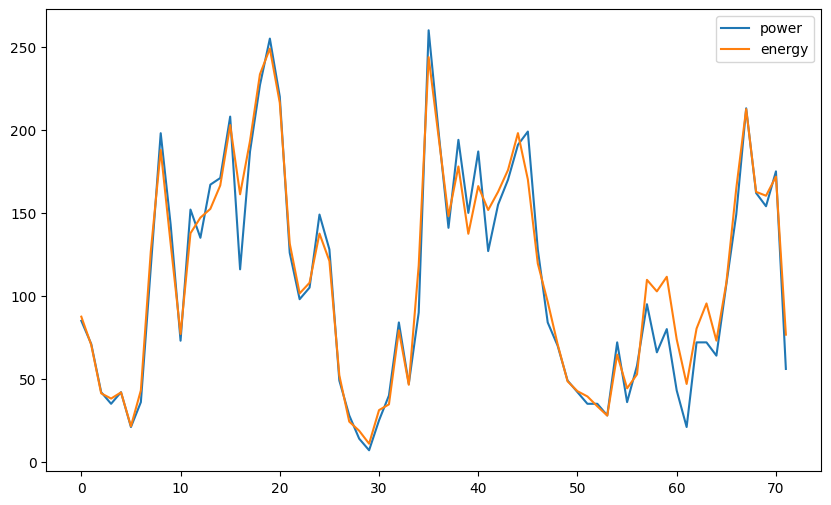

In [33]:
# Normalize the mobility aggregated charge power, calculate min, max, sum of power if there were EVs charging in the cluster then optimize this cluster's charging behavior to fit the curve
for i in [0]:#range(k):
    
    cluster = clustered[clustered['cluster']==i]
    emob_agg_e = [sum(x) for x in zip(*cluster['charge_energy_list'])] # energy in kWh
    emob_agg_p = [sum(x) for x in zip(*cluster['charge_power_list'])] # power in kW
    
    emob_max_p, emob_min_p,emob_tot_p = max(emob_agg_p), min(emob_agg_p), sum(emob_agg_p)
    print("Mobility data peak power:",emob_max_p,"Mobility data minimal power:",emob_min_p,"Mobility data total power:",emob_tot_p)

    emob_max_e, emob_min_e, emob_tot_e= max(emob_agg_e), min(emob_agg_e),sum(emob_agg_e)
    print("Mobility data peak energy:",emob_max_e,"Mobility data minimal energy:",emob_min_e,"Mobility data total energy:",emob_tot_e)
    
    if emob_max_p!=0:
        emob_agg_p_norm =  [p/emob_max_p for p in emob_agg_p]
        plt.figure(figsize=(10,6))
        plt.plot(emob_agg_p,label='power')
        plt.plot(emob_agg_e,label='energy')
        plt.legend()
        plt.savefig(f'{path}/369_9_cluster_{i}_agg_p_e.png')
        cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p
        normalized_tot_e = emob_tot_e/emob_max_p
        opt_res_code = opt_charge_profile(charge,discharge,net_normalized,cluster,emob_max_p,normalized_tot_e,i,path)

    else:
        index = list(cluster['event_index'])
        T = list(range(24))
        res_dict = {(e, t):0 for e in index for t in T} # Denormalize back to normal power value in kW
        # Convert the dictionary into a multi-index series to facilitate unstacking
        res = pd.Series(res_dict).unstack()
        # Save the restructured data to CSV
        res.to_csv(f'{path}/369_0_cluster_{i}.csv')
        

In [13]:
agg_e = [sum(x) for x in zip(*d['charge_energy_list'])] # energy in kWh
agg_p = [sum(x) for x in zip(*d['charge_power_list'])] # power in kW
max_p,min_p,tot_p = max(agg_p), min(agg_p), sum(agg_p)
max_e, min_e,tot_e= max(agg_e), min(agg_e),sum(agg_e)
print(tot_e)

79894.16666666669


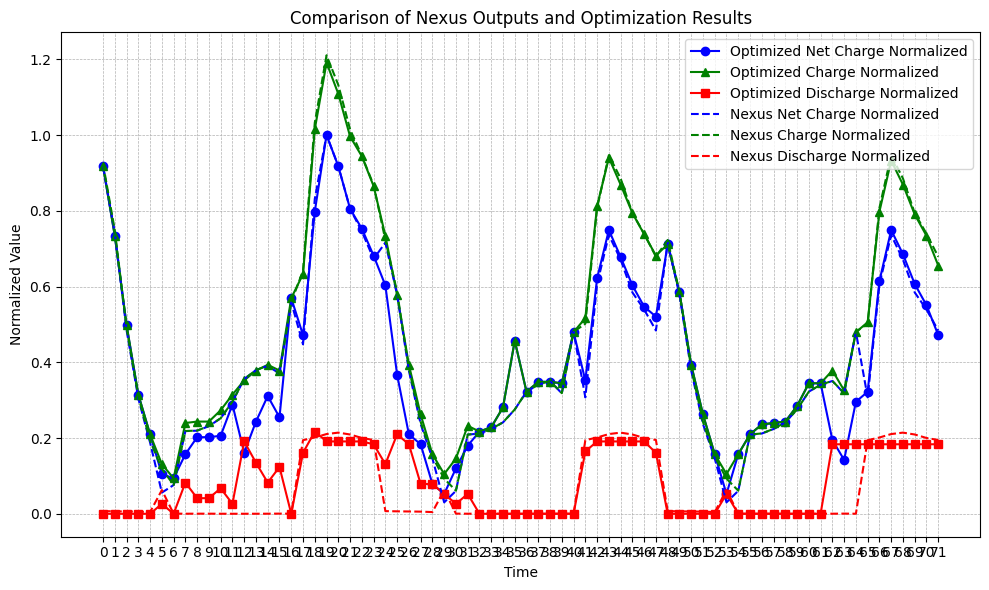

In [34]:
concat_charge = pd.DataFrame()
concat_discharge = pd.DataFrame()
for i in [0]:#range(k):
    charge_i = pd.read_csv(f'{path}/{grid}_cluster_{i}_charge.csv')
    concat_charge = pd.concat([concat_charge,charge_i],axis=0)
    discharge_i = pd.read_csv(f'{path}/{grid}_cluster_{i}_discharge.csv')
    concat_discharge = pd.concat([concat_discharge,discharge_i],axis=0)
    
concat_charge = concat_charge.rename(columns={'Unnamed: 0':'event_index'})
concat_discharge = concat_discharge.rename(columns={'Unnamed: 0':'event_index'})
concat_res = concat_charge-concat_discharge
concat_res.loc[:,'event_index'] = concat_charge['event_index']
concat_res.set_index('event_index', inplace=True)

# Cast to 0 is power too low
for column in concat_res.columns:
    if column != 'event_index':
        # Apply the condition and replace values
        concat_res.loc[:, column] = concat_res[column].apply(lambda x: 0 if abs(x) < 0.01 else x)
        
concat_charge.to_csv(f'{path}/concat_charge_power_all.csv')
concat_discharge.to_csv(f'{path}/concat_dicharge_power_all.csv')
concat_res.to_csv(f'{path}/concat_net_power_all.csv')
concat_sum = concat_res.sum().sum()
concat_max = concat_res.sum().max()
plt.figure(figsize=(10, 6))

# Optimized results with solid lines and markers
plt.plot(concat_res.sum()/concat_max, label='Optimized Net Charge Normalized', color='blue', linestyle='-', marker='o')
plt.plot(concat_charge.sum()[1:]/concat_max, label='Optimized Charge Normalized', color='green', linestyle='-', marker='^')
plt.plot(concat_discharge.sum()[1:]/concat_max, label='Optimized Discharge Normalized', color='red', linestyle='-', marker='s')

# Nexus outputs with dashed lines
plt.plot(net_normalized, label='Nexus Net Charge Normalized', color='blue', linestyle='--')
plt.plot(charge['normalized_profile'], label='Nexus Charge Normalized', color='green', linestyle='--')
plt.plot(discharge['normalized_profile'], label='Nexus Discharge Normalized', color='red', linestyle='--')

plt.title('Comparison of Nexus Outputs and Optimization Results')
plt.xlabel('Time')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(f'{path}/optimized_norm_power_vs_nexus.png')
plt.show()


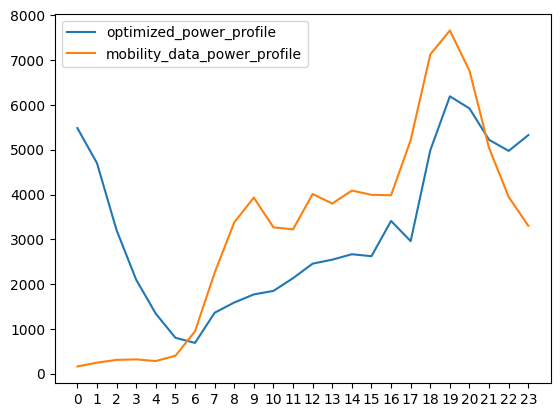

In [15]:
res_p = concat_res.sum()
plt.plot(res_p,label='optimized_power_profile')
plt.plot(agg_p, label='mobility_data_power_profile')
plt.legend()
plt.savefig(f'{path}/optimized_vs_mobility_power_profile.png')

In [16]:
concat_res = concat_res.sort_index()
time = pd.DataFrame(d['hourly_time_dict'].sort_index())
event_e = concat_res.apply(lambda row: [row[col]*time.at[row.name,'hourly_time_dict'][col]/60 for col in range(24)],axis=1)

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_34767/1169159873.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  event_e = concat_res.apply(lambda row: [row[col]*time.at[row.name,'hourly_time_dict'][col]/60 for col in range(24)],axis=1)


In [17]:
e = pd.DataFrame(event_e.tolist())
e.set_index(concat_res.index,inplace=True)
res_e = pd.Series(e.sum(),name='agg_e')
res_e_sum = res_e.sum()

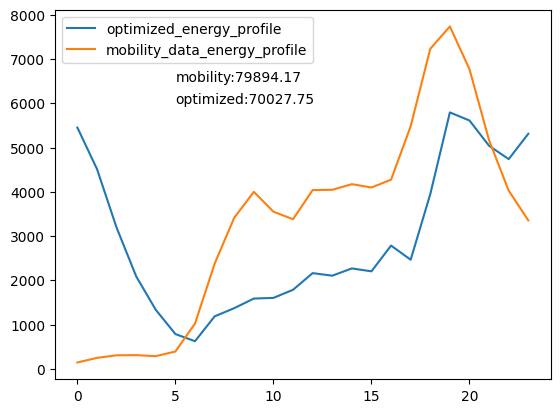

In [18]:
res_p = concat_res.sum()
# plt.plot(res_p,label='optimized_power_profile')
plt.plot(res_e,label='optimized_energy_profile')
plt.plot(agg_e,label='mobility_data_energy_profile')
plt.text(5,6500,f'mobility:{tot_e:.2f}')
plt.text(5,6000,f'optimized:{res_e_sum:.2f}')
plt.legend()
plt.savefig(f'{path}/optimized_vs_mobility_energy_profile.png')

In [19]:
res = pd.read_csv(f'{path}/concat_net_power_all.csv',index_col='event_index')
# for column in res.columns:
#     if column != 'event_index':
#         # Apply the condition and replace values
#         res.loc[:, column] = res[column].apply(lambda x: 0 if abs(x) < 0.1 else x)
powerlist = res.apply(lambda row: row.tolist(), axis=1)
powerlist.sort_index()

event_index
170        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
313        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
388        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
438        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.8, 0.0, ...
528        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                                 ...                        
1098969    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1099196    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1099198    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1099199    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1099243    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Length: 32208, dtype: object

In [20]:
d.sort_index()
d.loc[:,'optimized_power_list'] = powerlist
d.loc[:,'optimized_energy_list'] = d.apply(lambda row: [row['hourly_time_dict'][x]/60 * row['optimized_power_list'][x] for x in range(24)], axis=1)
d['process_list'] = d.apply(lambda row:get_timestamp_pair(row),axis=1)
d.to_pickle(f'{path}/grid_{grid}_matched_{scenario_year}.pkl')

In [21]:
d[['event_index','arr_time','park_end_time','process_list']].loc[d['process_list'].apply(lambda x: len(x)>0)]

,event_index,arr_time,park_end_time,process_list
313,313,2050-05-06 14:38:47.000000000,2050-05-06 16:32:23.000000000,"{(2050-05-06 14:38:00, 2050-05-06 15:59:00): [..."
438,438,2050-05-06 06:42:41.000000002,2050-05-06 19:17:51.999999982,"{(2050-05-06 07:00:00, 2050-05-06 07:59:00): [..."
545,545,2050-05-06 08:59:10.000000002,2050-05-06 18:06:26.999999982,"{(2050-05-06 08:59:00, 2050-05-06 11:59:00): [..."
576,576,2050-05-06 07:45:07.000000000,2050-05-06 10:50:04.000000000,"{(2050-05-06 07:45:00, 2050-05-06 09:59:00): [..."
869,869,2050-05-06 19:17:55.000000002,2050-05-06 23:56:02.999999982,"{(2050-05-06 22:00:00, 2050-05-06 23:56:00): [..."
...,...,...,...,...
1097972,1097972,2050-05-05 07:52:20.999999998,2050-05-06 07:26:07.000000018,"{(2050-05-06 00:00:00, 2050-05-06 00:59:00): [..."
1098580,1098580,2050-05-06 19:42:16.999999998,2050-05-09 07:43:57.000000000,"{(2050-05-06 20:00:00, 2050-05-06 23:59:00): [..."
1098782,1098782,2050-05-06 17:19:47.000000002,2050-05-09 07:35:18.000000004,"{(2050-05-06 18:00:00, 2050-05-06 18:59:00): [..."
1098828,1098828,2050-05-06 20:06:42.999999998,2050-05-07 14:40:47.000000000,"{(2050-05-06 22:00:00, 2050-05-06 23:59:00): [..."
